## Evaluate recommendations produced by get_recs.py

In [1]:
import pandas as pd
import numpy as np
import re
import json
import torch
import random
from probes import *
import numpy as np
import pickle
import matplotlib.pyplot as plt
torch.set_printoptions(profile="full")
import re
import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
import os
os.getcwd()

'/Users/jessicakahn/Documents/repos/probing_classifiers/goodreads_data'

In [3]:
import ast

In [4]:
df = pd.read_csv("goodreads_samples2.csv")
user_id_map = pd.read_csv("user_id_map.csv")
book_id_map = pd.read_csv("book_id_map.csv")
with open('author_data.json', 'r') as f:
    author_dict = json.load(f)
with open('book_data.json', 'r') as f:
    book_dict = json.load(f)
merged_df = pd.merge(df, book_id_map, left_on ='book_id',right_on='book_id_csv', how='left')
totals = merged_df.groupby('user_id')['rating'].agg(lambda x: (x >= 4).sum()).reset_index()

totals.columns = ['user_id','rating_count']
merged_df2 = pd.merge(merged_df, totals[totals.rating_count >= 3], on ='user_id', how='inner')
result_df = merged_df2.groupby('user_id')['book_id_y'].agg(list).reset_index()

In [5]:
# result_df.head()
outputs = torch.load('output_dict_500.pt', map_location=torch.device('cpu'))

In [103]:
# outputs.keys()
user_title_dict = {}
for i, row in result_df.iterrows():
    user_title_dict[row['user_id']] = [book_dict[str(i)]['title_without_series'] for i in row['book_id_y']]

In [7]:
str1 = "system\n\nCutting Knowledge Date: December 2023\nToday Date: 08 Nov 2025\n\nuser\n\nHi, I\'ve read and enjoyed the following books:"
str1b = "Hi, I\'ve read and enjoyed the following books:"
str2 = """  Only return the 5 books you recommend in JSON format like {"Books": {\'title\':..., \'author\':...}}, and nothing else.assistant\n\n"""
str3 = """Please recommend new books based on the user\'s reading preferences and only return the 5 books you recommend in JSON format like {"Books": {\'title\':..., \'author\':...}}, and nothing else.assistant"""

In [10]:
# Source - https://stackoverflow.com/a
# Posted by John La Rooy, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-19, License - CC BY-SA 3.0

book_dict_reverse = {v['title']: k for k, v in book_dict.items()}

print(len(book_dict_reverse.keys()), len(book_dict.keys()))

1767221 2360655


In [ ]:
def extract_all_titles(text):
    raw_titles = re.findall(r'"title"\s*:\s*"([^"]+)"', text)
    cleaned = [t.split(" by ")[0].strip() for t in raw_titles]
    return cleaned

In [49]:
# # there must be duplicate titles with different IDs
# counter = 0
# title_set = set()
# duplicates = set()
# for k,v in book_dict.items():
#     if v['title'] in title_set:
#         # print(v['title'])
#         duplicates.add(v['title'])
#     else:
#         title_set.add(v['title'])

# # All missing are due to duplicates
# missing = set(v['title'] for k, v in book_dict.items()).difference(duplicates.union(set(book_dict_reverse.keys())))
# print(len(missing))


In [50]:
def extract_books(entry):
    # Case 1: structured JSON-like string
    if isinstance(entry, dict) and "Books" in entry:
        return entry["Books"]
    
    if isinstance(entry, str) and entry.strip().startswith("{"):
        try:
            data = json.loads(entry)
            if "Books" in data:
                return data["Books"]
        except json.JSONDecodeError:
            pass  # fall through to regex

    # Case 2: free-form text like "Title (Series, #N) by Author"
    pattern = r"([A-Z][^()]*?(?:\([^)]*\))?\s+by\s+[A-Z][^,\.]+)"
    matches = re.findall(pattern, entry)

    books = []
    for m in matches:
        # Split into title and author
        title_part, author = m.split(" by ", 1)
        # try to merge book id in
        if title_part.strip() in book_dict_reverse:
            book_id = book_dict_reverse[title_part.strip()]
        else:
            book_id = None
        books.append({"title": title_part.strip(), "author": author.strip(), "book_id": book_id})
    
    return books

In [63]:
# extract titles and try to append book 
# Maybe do fuzzy matching for the ids? something like fuzzywuzzy
for k, values in outputs.items():
    values['baseline_recs'] = values['baseline_text'].split(str3)[1].replace("\n","") # Get the relevant part of string
    values['baseline_titles'] = extract_all_titles(values['baseline_recs'])
    values['baseline_ids'] = [book_dict_reverse[x] for x in values['baseline_titles'] if x in book_dict_reverse]

    # Now do the same for steered
    values['steered_recs'] = values['steered_text'].split(str3)[1].replace("\n","")
    values['steered_titles'] = extract_all_titles(values['steered_recs'])
    values['steered_ids'] = [book_dict_reverse[x] for x in values['steered_titles'] if x in book_dict_reverse]
    
    # And for the original sampled books
    values['hist'] = extract_books(values['baseline_text'].split(str3)[0].split(str1b)[1].replace(str1,""))
    # values['hist_ids'] = [book_dict_reverse[x] for x in values['baseline_titles'] if x in book_dict_reverse]

In [72]:
# Check for a user

test = outputs[215578]
print(test['steered_titles'], "\n", 
      test['baseline_titles'], "\n", 
      test['hist'])

['Dark Lover (Black Dagger Brotherhood, #1)', 'Blue Moon (Fairy-Tale Reform School, #2)', 'Blood Bound (Mercy Thompson, #4)', 'One Night in Shadow (Night Prince, #2)'] 
 ['Dark Lover (Black Dagger Brotherhood, #1)', 'Blue Moon (Blue Bloods, #4)', 'Moon Called (Mercy Thompson, #1)', 'Halfway to the Grave (Night Prince, #2)'] 
 [{'title': 'Dark Prince (Dark, #1)', 'author': 'Christine Feehan', 'book_id': '9549533'}, {'title': 'Misguided Angel (Blue Bloods, #5)', 'author': 'Melissa de la Cruz', 'book_id': '7747263'}, {'title': 'Silver Borne (Mercy Thompson, #5)', 'author': 'Patricia Briggs', 'book_id': '8266924'}, {'title': 'Once Burned (Night Prince, #1)', 'author': 'Jeaniene Frost  and All You Get Is Me by Yvonne Prinz', 'book_id': '7039218'}]


In [ ]:
# Some books won't show up by ID because book_dict_reverse only has 1 entry for all these rows
for k,v in book_dict.items():
    if v['title'] == 'Dark Lover (Black Dagger Brotherhood, #1)':
        print(k,v)

11116121 {'title': 'Dark Lover (Black Dagger Brotherhood, #1)', 'title_without_series': 'Dark Lover (Black Dagger Brotherhood, #1)', 'isbn': '', 'authors': [{'author_id': '20248', 'role': ''}], 'language_code': ''}
6980440 {'title': 'Dark Lover (Black Dagger Brotherhood, #1)', 'title_without_series': 'Dark Lover (Black Dagger Brotherhood, #1)', 'isbn': '1429517441', 'authors': [{'author_id': '20248', 'role': ''}], 'language_code': 'eng'}
8829405 {'title': 'Dark Lover (Black Dagger Brotherhood, #1)', 'title_without_series': 'Dark Lover (Black Dagger Brotherhood, #1)', 'isbn': '0749955228', 'authors': [{'author_id': '20248', 'role': ''}], 'language_code': ''}
13645152 {'title': 'Dark Lover (Black Dagger Brotherhood, #1)', 'title_without_series': 'Dark Lover (Black Dagger Brotherhood, #1)', 'isbn': '1436178398', 'authors': [{'author_id': '20248', 'role': ''}, {'author_id': '2870757', 'role': 'Narrator'}], 'language_code': 'eng'}
7889607 {'title': 'Dark Lover (Black Dagger Brotherhood, #1)

In [ ]:
# debugging
# user_title_dict[215578]

# [i for i in test['baseline_titles'] if i in user_title_dict[215578]]
# 'Dark Lover (Black Dagger Brotherhood, #1)', 'Moon Called (Mercy Thompson, #1)'
# title_set_215578 = [book_dict_reverse['Dark Lover (Black Dagger Brotherhood, #1)'],
#                     book_dict_reverse['Moon Called (Mercy Thompson, #1)']
#                                       ]
# print(title_set_215578) #20951187 6790045
# merged_df[(merged_df.book_id_y==6790045)]
# test2 = merged_df[merged_df.user_id==215578]
# test2.head()
# test2[test2.book_id_y==6487308]
# test3 = list(result_df[result_df.user_id==215578].book_id_y)
# 20951187 in test3
# [i for i in user_title_dict[215578] if i == 'Dark Lover (Black Dagger Brotherhood, #1)']
# merged_df.dtypes
# book_dict_reverse['Dark Lover (Black Dagger Brotherhood, #1)']

['Dark Lover (Black Dagger Brotherhood, #1)']

In [111]:
# book_dict['20951187']

In [ ]:
# for item in test:
#     if item in book_dict_reverse:
#         print(book_dict_reverse[item])
# book_dict_reverse['Moon Called (Mercy Thompson, #1)']

'6790045'

In [69]:
for user, values in outputs.items():
    values['titles'] = user_title_dict[user]
    values['baseline_count'] = 0
    values['steered_count'] = 0
    for title in values['titles']:
        if ((title in values['baseline_titles']) and (title not in values['hist'])):
            values['baseline_count'] += 1
        if ((title in values['steered_titles']) and (title not in values['hist'])):
            values['steered_count'] += 1

In [128]:
from fuzzywuzzy import fuzz

/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [137]:
outputs[215578]['steered_titles']

['Dark Lover (Black Dagger Brotherhood, #1)',
 'Blue Moon (Fairy-Tale Reform School, #2)',
 'Blood Bound (Mercy Thompson, #4)',
 'One Night in Shadow (Night Prince, #2)']

In [138]:
# st = outputs[215578]['steered_titles']
# st # book_dict['20951187']

best_match_key = None
best_score = 0

search_term = 'Blood Bound (Mercy Thompson, #4)'
for k, v in book_dict.items():
    score = fuzz.ratio(search_term, v['title'])
    if score > best_score:  # Set a minimum score threshold
        best_score = score
        best_match_key = k

print(best_score, best_match_key)

97 6282698


In [167]:
book_dict['24934535']
# book_dict['6282698']['title'] 
# len(outputs[215578]['baseline_ids'])
# in user_title_dict[215578]

{'title': 'Flunked (Fairy Tale Reform School, #1)',
 'title_without_series': 'Flunked (Fairy Tale Reform School, #1)',
 'isbn': '',
 'authors': [{'author_id': '114528', 'role': ''}],
 'language_code': 'en-CA'}

#### Precision @ k

In [155]:
# Check how many were successful
# for key, value in outputs.items(): # user IDs
#     if (value['baseline_count'] + value['steered_count']) > 0:
#         print(key,value['baseline_count'],value['steered_count'])

# Precision at k
# Should the denominator be all the titles returned by the LLM, or only the ones 
# that have an entry in book_dict? 
baseline_count = 0 
baseline_denom_count = 0
steered_count = 0 
steered_denom_count = 0

bigger_denom = 0
for key, value in outputs.items():
    baseline_denom_count += len(value['baseline_ids'])
    baseline_count += value['baseline_count']

    steered_denom_count += len(value['steered_ids'])
    steered_count += value['steered_count']
    bigger_denom += 5
    


In [156]:
print('Precision @ k: \n Baseline: ', 
      baseline_count/baseline_denom_count, ", ",
      baseline_count/bigger_denom,
      "\n Steered: ", steered_count/steered_denom_count, ", ",
      steered_count/bigger_denom)

Precision @ k: 
 Baseline:  0.1329073482428115 ,  0.0832 
 Steered:  0.1219047619047619 ,  0.0768


### Evaluate author gender

In [157]:
author_gender = pd.read_csv('final_dataset.csv')

In [158]:
author_gender.head()

,authorid,name,workcount,fan_count,gender,image_url,about,born,died,influence,average_rate,rating_count,review_count,website,twitter,genre,original_hometown,country,latitude,longitude
0,8409092,Jason Wallace,2,13,male,https://images.gr-assets.com/authors/148926684...,Jason Wallace is related to Tolkien and a desc...,NaN,NaN,NaN,3.74,1028,175,NaN,NaN,NaN,Cheltenham,United Kingdom,51.90006,-2.07972
1,5796406,Rosan Hollak,4,0,unknown,https://s.gr-assets.com/assets/nophoto/user/u_...,NaN,NaN,NaN,NaN,3.73,15,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8421525,Nanna Foss,6,156,female,https://images.gr-assets.com/authors/140908587...,Danish YA writer. <br /><br />I make up storie...,NaN,NaN,NaN,4.35,1172,205,http://www.nannafoss.dk,NaN,"fantasy,fiction,paranormal",NaN,NaN,NaN,NaN
3,158146,Terri Savelle Foy,23,125,female,https://images.gr-assets.com/authors/147569460...,"For years, Terri Savelle Foy’s life was averag...",NaN,NaN,NaN,4.56,1054,151,http://www.terri.com,terrisavellefoy,"religion and spirituality,self help,spirituality",NaN,NaN,NaN,NaN
4,15340731,Vishwas Nangare Patil,1,127,unknown,https://s.gr-assets.com/assets/nophoto/user/u_...,NaN,NaN,NaN,NaN,4.15,725,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
with open('/Users/jessicakahn/Documents/repos/probing_classifiers/goodreads_data/gender_dict_500.json', 'r') as f:
    gender_dict = json.load(f)

In [185]:
# list(gender_dict.keys())[0]
# author_gender[author_gender.authorid==5796406].gender

In [164]:
# Append user gender to dict
for k,v in outputs.items():
    v['user_gender'] = gender_dict[str(k)]

In [193]:
# outputs[215578]['baseline_ids']
# type(book_dict[outputs[215578]['baseline_ids'][0]]['authors'][0]['author_id'])
author_gender[author_gender.authorid==20248].gender.values[0]

'unknown'

In [198]:
# author_gender.authorid

In [204]:
for k,v in outputs.items():
    baseline_gender_list = []
    steered_gender_list = []
    for book in v['baseline_ids']:
        author_id = int(book_dict[book]['authors'][0]['author_id'])
        if author_id in author_gender.authorid:
            try:
                baseline_gender_list.append(author_gender[author_gender.authorid==author_id].gender.values[0])
            except:
                pass
    for book in v['steered_ids']:
        author_id = int(book_dict[book]['authors'][0]['author_id'])
        if author_id in author_gender.authorid:
            try:
                steered_gender_list.append(author_gender[author_gender.authorid==author_id].gender.values[0])
            except:
                pass

    v['baseline_gender_list'] = baseline_gender_list
    v['steered_gender_list'] = steered_gender_list
    

In [210]:
outputs[215578]['gender_list']

['unknown', 'female']

In [216]:
# sum author genders by baseline and steered
baseline_count = 0
steered_count = 0
baseline_f = 0
steered_f = 0
baseline_u = 0
steered_u = 0
baseline_m = 0
steered_m = 0
for k,v in outputs.items():
    baseline_count += len(v['baseline_ids'])
    steered_count += len(v['steered_ids'])
    for g in v['baseline_gender_list']:
        baseline_f += g=='female'
        baseline_u += g=='unknown'
        baseline_m += g=='male'
    for g in v['steered_gender_list']:
        steered_f += g=='female'
        steered_u += g=='unknown'
        steered_m += g=='male'
            

In [223]:
# Increased the proportion of female authors
print(" Female : Unknown : Male \n ",
    baseline_f/baseline_count, baseline_u/baseline_count, baseline_m/baseline_count, "\n",
      steered_f/steered_count, steered_u/steered_count,steered_m/steered_count)

 Female : Unknown : Male 
  0.20830670926517572 0.042172523961661344 0.2613418530351438 
 0.2088888888888889 0.04888888888888889 0.2450793650793651


In [226]:
with open(f'probes_from_aws/model27.pkl','rb') as f:
    regr = pickle.load(f)

In [ ]:
# regr.classes_ 
# So male is 1

array(['Female', 'Male'], dtype='<U6')

In [48]:
extract_books(outputs[141311]['steered_text'])

[{'title': "Cutting Knowledge Date: December 2023\nToday Date: 13 Nov 2025\n\nuser\n\nHi, I've read and enjoyed the following books: Some Are Born to Sweet Delight",
  'author': 'Nadine Gordimer'},
 {'title': 'Ghost Wars: The Secret History of the CIA, Afghanistan, and bin Laden from the Soviet Invasion to September 10, 2001',
  'author': 'Steve Coll'},
 {'title': 'Blinding Love 2 (Blinding Love, #2)', 'author': 'Liv Bennett'},
 {'title': 'Leaving the Comfort Cafe',
  'author': 'Dawn DeAnna Wilson  and Witch (Wicked'}]

In [51]:
outputs[141311]['baseline_text']

'system\n\nCutting Knowledge Date: December 2023\nToday Date: 13 Nov 2025\n\nuser\n\nHi, I\'ve read and enjoyed the following books: Some Are Born to Sweet Delight by Nadine Gordimer,  \n        Ghost Wars: The Secret History of the CIA, Afghanistan, and bin Laden from the Soviet Invasion to September 10, 2001 by Steve Coll,Blinding Love 2 (Blinding Love, #2) by Liv Bennett,Leaving the Comfort Cafe by Dawn DeAnna Wilson  and Witch (Wicked, #1) by Nancy Holder.  Please recommend new books based on the user\'s reading preferences and only return the 5 books you recommend in JSON format like {"Books": {\'title\':..., \'author\':...}}, and nothing else.assistant\n\n{\n  "Books": [\n    {"title": "Disobedience", "author": "Naomi Alderman"},\n    {"title": "The Looming Tower", "author": "Lawrence Wright"},\n    {"title": "The Seven Husbands of Evelyn Hugo", "author": "Taylor Jenkins Reid"},\n    {"title": "The Other Mrs. Miller", "author": " Allison Dickson"},\n    {"title": "The Invisible L

In [52]:
outputs[141311]['hist']

[{'title': 'Some Are Born to Sweet Delight', 'author': 'Nadine Gordimer'},
 {'title': 'Ghost Wars: The Secret History of the CIA, Afghanistan, and bin Laden from the Soviet Invasion to September 10, 2001',
  'author': 'Steve Coll'},
 {'title': 'Blinding Love 2 (Blinding Love, #2)', 'author': 'Liv Bennett'},
 {'title': 'Leaving the Comfort Cafe',
  'author': 'Dawn DeAnna Wilson  and Witch (Wicked'}]

In [37]:
user_title_dict[141311]

['Men of the Otherworld (Otherworld Stories, #I)',
 'The Fellowship of the Ring (The Lord of the Rings, #1)',
 'Sisters Red (Fairytale Retellings, #1)',
 'Cruel Beauty (Cruel Beauty Universe, #1)',
 'Longbourn',
 'Wondrous Strange (Wondrous Strange, #1)',
 'Crossroads of Twilight (Wheel of Time, #10)',
 'The Rules (Project Paper Doll, #1)',
 'Perdition (Dred Chronicles, #1)',
 'Mirror Sight (Green Rider, #5)',
 'Cress (The Lunar Chronicles, #3)',
 'Feed (Newsflesh Trilogy, #1)',
 'Frost',
 'She-Wolves: The Women Who Ruled England Before Elizabeth']

In [11]:
# (data_dict)[14]
# really need the user ids in the output - next run needs that added

In [12]:
str1 = "system\n\nCutting Knowledge Date: December 2023\nToday Date: 08 Nov 2025\n\nuser\n\nHi, I\'ve read and enjoyed the following books:"
str2 = """  Only return the 3 books you recommend in JSON format like {"Books": {\'title\':..., \'author\':...}}, and nothing else.assistant\n\n"""
str3 = """Only return the 3 books you recommend in JSON format like {"Books": {\'title\':..., \'author\':...}}, and nothing else.assistant"""
pattern = r"\s*(?:,|and)\s*"

In [15]:
# # Extract the recommendations and originals
# for alpha, dic in outputs.items():
#     for user, values in dic.items():
#         values['baseline_recs'] = universal_repeated_key_parser(values['baseline_text'].split(str3)[1].replace("\n",""))
#         values['steered_recs'] = universal_repeated_key_parser(values['steered_text'].split(str3)[1].replace("\n",""))
#         if (values['baseline_recs'] is None) or (values['steered_recs'] is None):
#             print(alpha, user)
    

In [16]:
outputs[0.1][279388]['baseline_recs']

KeyError: 0.1

In [77]:
book_dict['2342881']

{'title': 'The Secret Diaries of Charlotte Brontë',
 'title_without_series': 'The Secret Diaries of Charlotte Brontë',
 'isbn': '006164837X',
 'authors': [{'author_id': '806500', 'role': ''}],
 'language_code': 'eng'}

In [87]:
# result_df.head(2)
# user_title_dict

In [64]:
# data = json.loads((outputs[10][189064]['steered_recs']))
outputs[0.1][279388]['baseline_text'].split(str3)[1].replace("\n","")
# outputs[0.1][46163]['steered_text'].split(str3)[1].replace("\n","")

'{"Books": {    "title": "The Bone Collector",    "author": "Jeffery Deaver",    "genre": "Thriller"},{"Books": {    "title": "Fool Me Once",    "author": "Harlan Coben",    "genre": "Thriller"},{"Books": {    "title": "Star Trek: The Next Generation Technical Manual",    "author": "Michael Okuda",    "genre": "Reference"}}'

In [96]:
outputs[1][224839].keys()
# ['titles']

dict_keys(['baseline_text', 'steered_text', 'pre_hidden', 'post_hidden', 'baseline_recs', 'steered_recs', 'titles'])

In [113]:
# outputs[1].keys()
for alpha, user_ids in outputs.items():
    for user, values in user_ids.items():
        values['titles'] = user_title_dict[user]
        values['baseline_count'] = 0
        values['steered_count'] = 0
        for title in values['titles']:
            if title in values['baseline_text']:
                values['baseline_count'] += 1
            if title in values['steered_text']:
                values['steered_count'] += 1

In [101]:
default_value = {}
small_dict = {key: {'baseline':[], 'steered':[]} for key in outputs}
 # = {al_dict.keys()}
for k,v in outputs.items(): #alpha values

    for key, value in v.items(): # user IDs
        for key1, value1 in value.items(): #values per user ID
            if key1 == 'baseline_count':
                small_dict[k]['baseline'].append(value1)
            elif key1 == 'steered_count':
                small_dict[k]['steered'].append(value1)

In [91]:
for k,v in outputs.items(): #alpha values
    for key, value in v.items(): # user IDs
        if (value['baseline_count'] + value['steered_count']) > 6:
            print(k,key,value['baseline_count'],value['steered_count'])

TypeError: string indices must be integers, not 'str'

In [119]:
outputs[0.1][163356]['titles']

['Traveling Mercies: Some Thoughts on Faith',
 'Turtles All the Way Down',
 'Freckles (Limberlost #1)',
 'The Biggest Bear',
 'Tuesdays with Morrie',
 'The Book Thief',
 'The Trees of the Dancing Goats',
 'Darfur and the Crime of Genocide',
 'I Never Promised You a Rose Garden',
 'My Family and Other Animals (Corfu Trilogy, #1)']

In [123]:
outputs[10][163356]['baseline_text']
# outputs[0.1][163356]['titles']

'system\n\nCutting Knowledge Date: December 2023\nToday Date: 11 Nov 2025\n\nuser\n\nHi, I\'ve read and enjoyed the following books: Turtles All the Way Down by John Green,  \n    Darfur and the Crime of Genocide by John Hagan  and Freckles (Limberlost #1) by Gene Stratton-Porter.  Only return the 3 books you recommend in JSON format like {"Books": {\'title\':..., \'author\':...}}, and nothing else.assistant\n\n{\n  "Books": [\n    {"title": "The Perks of Being a Wallflower", "author": "Stephen Chbosky"},\n    {"title": "The Book Thief", "author": " Markus Zusak"},\n    {"title": "Island of the Blue Dolphins", "author": "Scott O\'Dell"}\n  ]\n}'

## Below is with the old outputs format 

In [23]:
# data_dict

In [27]:
# output
# search in user data for these users
for i in output:
    for k,v  in data_dict.items():
        counter = 0
        for j in v:
            if j in i['orig']:
                counter += 1
        if counter >= 3:
            i['hist'] = v
            i['hist_len'] = len(v)
            break
    


In [93]:
# list(book_dict.keys())[0:5]
# book_dict['5333265']

In [92]:
# list(book_dict_reverse.keys())[0:5]

In [50]:
pattern = r"([A-Z][^()]*?(?:\([^)]*\))?\s+by\s+[A-Z][^,\.]+)"
for i in output:
    i['baseline_recs'] = [b.strip(" ,.\n") for b in re.findall(pattern, i['baseline_output'].split(spl_str)[1])]
    i['steered_recs'] = [b.strip(" ,.\n") for b in re.findall(pattern, i['steered_output'].split(spl_str)[1])]

### Do MF recommendation (from MF-recommender.ipynb in this folder)

In [5]:
# Filter books to only ones with 10 or more ratings
book_count = merged_df2.groupby('book_id_y').count().reset_index()
books = book_count[book_count.user_id>=10]['book_id_y']
int_df = merged_df2[merged_df2.book_id_y.isin(books)]
user_ids_fromdf = int_df.user_id.unique()

In [6]:
# Build interaction matrix
from scipy.sparse.linalg import svds

R_df = int_df.pivot(index = 'user_id', columns ='book_id_y', values = 'rating').fillna(0)
# R_df.head()
R = R_df.to_numpy()

user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)


U, sigma, Vt = svds(R_demeaned, k = 50)
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)

In [ ]:
# Now need the parsed book titles/ ids so can compare

### Plot the predicted probabilities

In [63]:
os.getcwd()

'/Users/jessicakahn/Documents/repos/probing_classifiers/goodreads_data'

In [64]:
with open(f'probes_from_aws/model27.pkl','rb') as f:
    regress_27 = pickle.load(f)

In [65]:
for key, result in outputs.items():
    b = regress_27.predict_proba(
        result['pre_hidden'].mean(dim=1).squeeze(0).reshape(1, -1).detach().cpu().numpy()
    )[0][0]
    result['unsteered_proba'] = b
    s = regress_27.predict_proba(
        result['post_hidden'].mean(dim=1).squeeze(0).reshape(1, -1).detach().cpu().numpy()
    )[0][0]
    result['steered_proba'] = s

In [75]:
outputs[215578]['unsteered_proba']

0.9964886905260317

In [79]:
# Make 2 lists of proba, baseline and steered
small_dict = {'baseline':[], 'steered':[]}
for key, value in outputs.items(): # user_ids
    for key1, value1 in value.items(): #values per user ID
        if key1 == 'unsteered_proba':
            small_dict['baseline'].append(value1)
        elif key1 == 'steered_proba':
            small_dict['steered'].append(value1)

In [ ]:
# small_dict
# len(small_dict['baseline'])

500

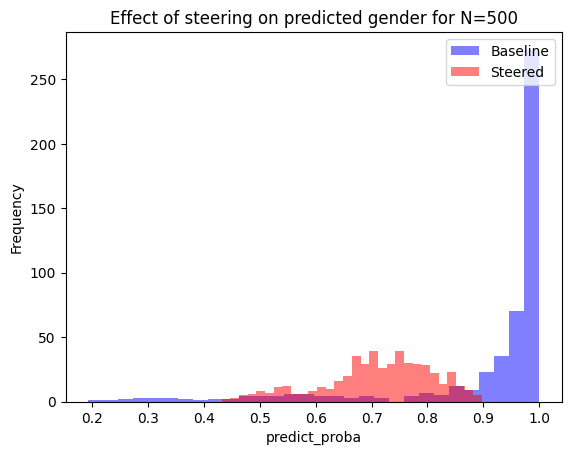

In [90]:

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the first histogram
ax.hist(small_dict['baseline'], bins=30, alpha=0.5, label='Baseline', color='blue')

# Plot the second histogram on the same axes
ax.hist(small_dict['steered'], bins=30, alpha=0.5, label='Steered', color='red')

# Add a legend to distinguish the series
ax.legend(loc='upper right')

# Add titles and labels for clarity
k = len(small_dict['baseline'])
ax.set_title(f'Effect of steering on predicted gender for N={k}')
ax.set_xlabel('predict_proba')
ax.set_ylabel('Frequency')

# Display the plot
plt.show()